In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt 
from statsmodels import graphics
from statsmodels.tsa.stattools import adfuller, zivot_andrews
from statsmodels.graphics.api import qqplot
import warnings


import seaborn as sns
%matplotlib inline

____

# Introducción

El ex general de la KGB Sakharovsky dijo: "En el mundo de hoy, cuando las armas nucleares han dejado obsoleta la fuerza militar, el terrorismo debería convertirse en nuestra arma principal". Ahora, la mayoría de los analistas creen que el final de la Guerra Fría provocó una disminución dramática en el terrorismo patrocinado por el estado. 

Aunque los acontecimientos del 11 de septiembre de 2001 llamaron la atención del mundo sobre el terrorismo, la comunidad internacional experimentó un fuerte aumento del terrorismo transnacional a partir de fines de la década de 1960. Los terroristas participan en una amplia variedad de operaciones, incluidos asesinatos, ataques armados, bombardeos, secuestros y secuestros aéreos. Tales incidentes son particularmente atroces porque a menudo se dirigen a víctimas inocentes que no forman parte del aparato de toma de decisiones en el que los terroristas intentan influir.

El conjunto de datos TERRORISM.XLS contiene los valores trimestrales de varios tipos de incidentes terroristas nacionales y transnacionales durante el período 1970Q1–2010Q4. La definición precisa de las variables se discute en [Enders, Sandler y Gaibulloev (2011)](https://journals.sagepub.com/doi/pdf/10.1177/0022343311398926). Si examinan los datos, puede ver que el número de ambos tipos de incidentes comienza a disminuir a principios de la década de 1990 como resultado de la desintegración de la Unión Soviética en 1991Q4. Hay una segunda disminución después de 1997Q4. El departamento de Estado de EE. UU. Atribuye esta disminución a las medidas diplomáticas y policiales que dificultan la operación de los terroristas.

In [ ]:
terrorism = pd.read_excel(r'Terrorism.xlsx')

In [ ]:
terrorism.index = pd.period_range('1970-01-01', '2010-12-01', freq='Q')

In [ ]:
terrorism.head()

In [ ]:
plt.figure(figsize=(12,6))
terrorism.Domestic.plot()
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend()

In [ ]:
plt.figure(figsize=(12,6))
terrorism.Transnational.plot(color='r')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend()

_____

# Modelo para el análisis

El análisis de intervención permite una prueba formal de un cambio en la media de una serie de tiempo.
Se considera el siguiente modelo para estudiar si las negociaciones diplomáticas tuvieron un efecto o no s0obre el número de incidentes. 

$y_t = a_0 + a_1 y_{t-1} + c_0 z_t + e_t$, $|a_1|<1$

Donde $z_t$ es la variable de intervención, que toma el valor de 1 para fchas mayor o igual a 1997:Q4, y 0 caso contrario. $e_t$ es un error ruido blanco.

In [ ]:
terrorism['z'] = (terrorism.index >= '1997-10-01').astype(int)

In [ ]:
terrorism.head()

Para entender la naturaleza del modelo, escribimos la solución del modelo en el momento t, como

$y_t = a_0(1+a_1+a_1^2+...)+c_0\sum_{i=0}^{\infty}{a_1^iz_{t-i}}+\sum_{i=0}^{\infty}{a_1^ie_{t-i}}$


$y_t = \frac{a_0}{1-a_1}+c_0\sum_{i=0}^{\infty}{a_1^iz_{t-i}}+\sum_{i=0}^{\infty}{a_1^ie_{t-i}}$

Es útil escribir la solución j períodos hacia adelante, es decir,

$y_{t+j} = \frac{a_0}{1-a_1}+c_0\sum_{i=0}^{j}{a_1^iz_{t+j-i}}+\sum_{i=0}^{j}{a_1^ie_{t+j-i}}$

1. El valor medio de largo plazo de $y_t$ es $\frac{a_0}{1-a_1}$, cuando $z_t=0$
2. El valor medio de largo plazo de $y_t$ es $\frac{a_0+c_0}{1-a_1}$, cuando $z_t=1$
3. El efecto de la intervención en el largo plazo es $\frac{c_0}{1-a_1}$

Todo esto asumiendo que $|a_1|<1$

## Extensión

El modelo previo puede ser escrito de una manera mas generalizada 

$y_t = a_o + A(L)y_t + c_0z_t + B(L)e_t$

Donde $A(L)$ y $B(L)$ spn polinomios del operador de rezago L.

Por otro lado, la intervención puede ser más compleja: 

1. Una intervenci'on que se mantiene por siempre
2. Una intervenci'on en un solo periodo
3. Una intervenci'on que va creciendo en intensidad y luego se mantiene
4. Una intervenci'on que decrece en intensidad 


<img src="fig10.png">[1](#Notas)

## Estimación de la intervención

La forma lineal del modelo de intervención supone que los coeficientes son invariables luego de  la intervención. Una comprobación útil de este supuesto es  la estimación de los modelos $ARIMA(p,d,q)$ más apropiados para los períodos pre y posintervención. Si los dos modelos ARIMA son bastante diferentes, es probable que los coeficientes de promedio móvil y autorregresivo hayan cambiado.

Por lo general, no hay suficientes observaciones previas y posteriores a la intervención para estimar dos modelos separados. En tales casos, el investigador debe utilizar el modelo ARIMA que mejor se ajuste durante el período de datos más largo. El procedimiento descrito a continuación es típico en la mayoría de los estudios de intervención.

1. Usar la parte de data "más larga" (ya sea pre o post intervencion) para encontrar un conjunto de modelos ARIMA. Se puede usar el test Zivot y Andrews para confirmar cambios estructurales
    - Se debe asegurar que la serie es estacionaria.
    - Si se sospecha no estacioanriedad, realizar pruebas de raíz unitaria sobre la sección larga de datos. 
    - Si hay raíz unitaria, realizar el análisis de intervención sobre $\Delta y_t$
    - Recuerde que si hay raíz unitaria, un pulso permanente actua como un drift

2. Estimar varios modelos sobre la muestra entera, incluyendo el efecto de la intervención.

3. Realizar el diagnóstico de las ecuaciones estimadas
    - Esta sección es fundamental. Recuerde que en el paso 2 estimamos un modelo (obtenido con la parte larga de datos) usando  todos los datos. Recuerde que un buen modelo debe tener: Todos los coeficientes debe ser estadisticamente significativos (considere la parsimonia).
    - Los residuos deben ser ruido blancos. Si los residuos esta correlacionados, el modelo estimado no imita el proceso que genero los datos. Si los residuos no son normalmente distribuidos, las pruebas de hipotesis no son confiables, si la muestra es pequena.
    - Usar AIC y BIC para comparar posibles modelos.
    
Considere que la variable intervención puede afectar a la variable de interés con cierto rezago _d_. Por ejemplo el modelo  de intervención pudiera ser:

$y_t = a_o + A(L)y_t + c_0z_{t-d} + B(L)e_t$


In [ ]:
terrorism_pre = terrorism[(terrorism.z == 0)]
terrorism_post = terrorism[(terrorism.z == 1)]

print(len(terrorism_pre))
print(len(terrorism_post))

terrorism_pre.head()

In [ ]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(terrorism_pre.Transnational, lags=40, ax=ax1)


#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(terrorism_pre['Transnational'], lags=40, ax=ax2)

In [ ]:
# Generar el modelo
model = sm.tsa.SARIMAX(terrorism_pre.Transnational, exog=  , order=(2,0,0), trend='c')

# Estimar los parametros del modelo
results = model.fit()

print(results.summary())

$y_t = a_0 + a_1 y_{t-1} + a_2y_{t-2}+c_0 z_t + e_t$, $|a_1|<1$

In [ ]:
# Generar el modelo
model = sm.tsa.SARIMAX(terrorism.Transnational, exog = terrorism.z, order=(2,0,0), trend='c')

# Estimar los parametros del modelo
results = model.fit()

print(results.summary())

In [ ]:
resid=results.resid.values

In [ ]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax1)


#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=20, ax=ax2)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

_____________

# Modelo de rezagos distribuidos


Considere el modelo:

$y_t = a_o + A(L)y_{t-1} + C(L)z_{t} + B(L)e_t$

Donde $A(L)$, $B(L)$, $C(L)$ son polinomios del operador de rezago L.

Ahora se permite que la variable de intervención sea un proceso estacionario exógeno. Este modelo se denomina modelo de rezagos distribuidos en el que se distribuyen los efectos de $z_t$ sobre $y_t$ por varios periodos.

El polinomio $C(L)=c_0 + c_1L +c_2 L^2+...$ se llama _funcion de trasnferenia_. Esta muestra como un movimiento de la variable exógena $z_t$ afecta en el tiempo a $y_t$. Los coeficientes de esta función de transferencia se denominan pesos.

**Importante:** la función de trasnfrencia es independiente de la evolución de $y_t$. Los errores $e_t$ no tiene efecto alguno sobre la secuencia $z_t$ tal que $E(z_te_{t-s})=0$.

Si $c_0=0$, el valor contemporáneo de $z_t$ no tiene efecto sobre $y_t$. En este caso $z_t$ es llamado a _leading indicator_ en la predicción de $y_{t+1}$ que puede ser hecha en el periodo t usando $z_t$, $z_{t-1}$, ... sin necesidad de conocer la predicción de $z_{t+1}$.

## Modelo de autoregressive distributed lag (ADL)


Considere el modelo:

$y_t = a_0 + A(L)y_{t-1} + C(L)z_{t} + e_t$

A diferencia del modelo de intervención pura, no existe  un período pre-post intervención. No podemos estimar un ADL de la misma manera que solíamos estimar un modelo de intervención. Sin embargo, los métodos son similares en que el objetivo es estimar un modelo parsimonioso.

Para poner en contexto, suponga que el modelo es $y_t = a_0 + a_1y_{t-1} + c_1z_{t} + e_t$. donde $z_t = d_1z_{t-1}+u_t$. Donde $e_t$ es un ruido blanco tal que $E(z_t e_{t-i})=0$, es decir $z_t$ es independiente de $e_t$.


In [2]:
n =120

y = np.zeros(n) 

z = np.zeros(n) 
 

for i in range(0,n):
    
    e = np.random.normal(0, 1, 1)
    u = np.random.normal(0, 1, 1)
    
    
    z[i] = 0.5*z[i - 1] + u
    
    y[i] = 0.8*y[i - 1] + 0.5*z[i]+e

y = pd.Series(y)    

z = pd.Series(z)

frame = {'y':y,'z':z}

In [3]:
df = pd.DataFrame(frame) 
df.index = pd.period_range('2001-01-01', '2010-12-01', freq='M')

______

# Identificación y Estimación

Para entender el procedimiento, considere que estamos interesados em estimar el siguiente modelo

$y_t = a_0 + a_1y_{t-1} + c_0z_{t} + e_t$ donde $z_t = d_1z_{t-1}+u_t$

## Paso 1: Estimar un proceso AR para  $z_t$ 

Estimar un proceso AR para la secuencia $z_t$ de la manera tradicional.  Los residuos estimados $\hat{u}_{t}$ se denominan valores filtrados de la serie $z_t$. Estos valores filtrados pueden interpretarse como las innovaciones puras de la serie $z_t$.

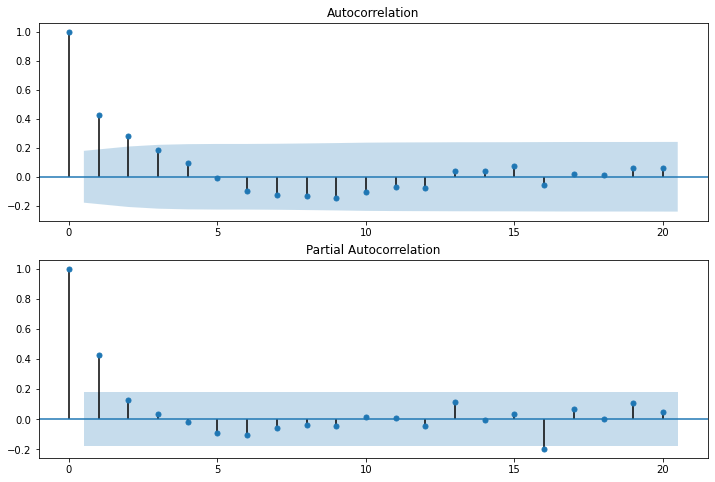

In [4]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.z, lags=20, ax=ax1)


#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.z, lags=20, ax=ax2)

In [4]:
aic = pd.DataFrame(np.zeros((6,6), dtype=float))
bic = pd.DataFrame(np.zeros((6,6), dtype=float))
hqic = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(z, order=(p,0,q), trend='c',enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic.iloc[p,q] = res.aic
            bic.iloc[p,q] = res.bic
            hqic.iloc[p,q] = res.hqic
        except:
            aic.iloc[p,q] = np.nan
            bic.iloc[p,q] = np.nan
            hqic.iloc[p,q] = np.nan

In [7]:
hqic

,0,1,2,3,4,5
0,0.000000,338.505616,337.843253,336.858625,339.687680,341.694169
1,333.716243,336.847702,339.250902,339.827504,338.387576,341.422389
2,336.847439,339.980255,335.509093,337.542938,341.417881,342.897742
3,338.636866,336.948046,337.098417,340.865041,343.627364,345.239828
4,335.769812,338.180730,341.046869,344.163825,344.832119,345.287057
5,338.632227,341.166699,344.176883,347.294109,350.094806,348.543274


In [12]:
model = sm.tsa.statespace.SARIMAX(df.z, order=(1,0,0), trend=None)
results = model.fit()
resid = results.resid
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      z   No. Observations:                  120
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -162.258
Date:                Thu, 30 Jul 2020   AIC                            328.516
Time:                        17:07:23   BIC                            334.091
Sample:                    01-31-2001   HQIC                           330.780
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4649      0.092      5.033      0.000       0.284       0.646
sigma2         0.8732      0.094      9.336      0.000       0.690       1.056
Ljung-Box (Q):                       36.37   Jarque-

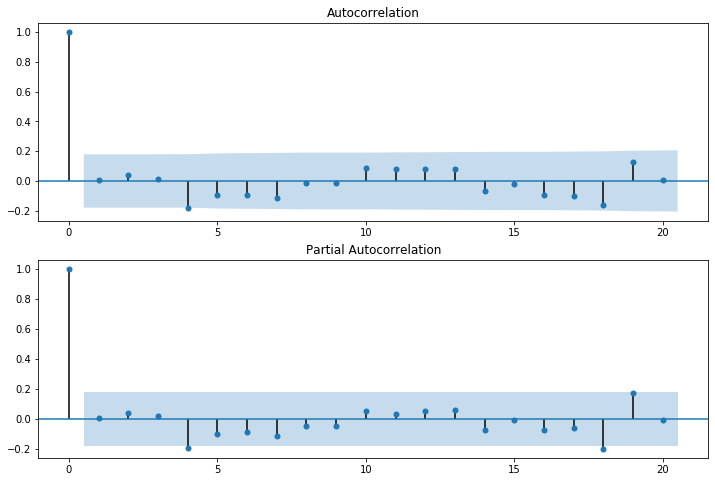

In [13]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax1)


#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=20, ax=ax2)

## Paso 2: Identificar la función $C(L)$

El correlograma cruzado entre $y_{t}$ y $z_{t-i}$ pueden ayudar a identificar la forma de $C(L)$. Recuerde que los picos en el correlograma cruzado indican valores distintos de cero de $c_i$. En la práctica, el análisis del correlograma cruzado sugerirá varias funciones de transferencia.

Por supuesto, las covarianzas cruzadas de muestra no se ajustarán con precisión a sus valores teóricos. Bajo la hipótesis nula de que las correlaciones cruzadas son todas cero, la varianza muestral del coeficiente de correlación cruzada i converge asintóticamente a $(T - i)^{−1}$ donde T = número de observaciones usadas. 

Supongamos que $r_{yz}(i)$ denota el coeficiente de correlación cruzada de la muestra entre $y_{t}$ y $z_{t−i}$. Bajo la hipótesis nula de que los valores verdaderos de $\rho_{yz}(i)$ son todos iguales a cero, la varianza de $r_{yz}(i)$ converge a 

$var(r_{yz}(i))= (T-i)^{−1} $

Por ejemplo, con 100 observaciones , la desviación estándar del coeficiente de correlación cruzada es aproximadamente igual a 0.10. Si el valor calculado de  $r_{yz}(1)$  excede 0.2 (o es menor que −0.2), la hipótesis nula puede ser rechazada. Las correlaciones cruzadas significativas en el rezago i indican que una innovación en $z_t$afecta el valor de $y_{t+i}$. Para probar la significancia estadística de las primeras k correlaciones cruzadas, use la estadística


$ Q = T (T + 2) \frac{\sum_{i=0}^k{r^2_{yz}(i)}}{T-k}$

Asintóticamente, Q tiene una distribución $\chi^2$ con $(k - p_1 - p_2)$ grados de libertad donde $p_1$ y $p_2$ denotan el número de coeficientes distintos de cero en $A(L)$ y $C(L)$, respectivamente.

In [15]:
r = sm.tsa.stattools.ccf(df.z,df.y, unbiased=True)
r[0:9]

array([ 0.38976216,  0.1486288 ,  0.0096145 , -0.03508591, -0.13855776,
       -0.17982133, -0.1232058 , -0.05234173,  0.03632339])

In [16]:
T =len(df.z)

for i in range(0, 10):
        
    print('correlacion',i, '=', format(r[i]/(2*(T-i)**(-0.5)),'.2f'), ', cov =',
          format(r[i],'.2f'), '2 * Var =', format(2*(T-i)**(-0.5),'.4f'))

correlacion 0 = 2.13 , cov = 0.39 2 * Var = 0.1826
correlacion 1 = 0.81 , cov = 0.15 2 * Var = 0.1833
correlacion 2 = 0.05 , cov = 0.01 2 * Var = 0.1841
correlacion 3 = -0.19 , cov = -0.04 2 * Var = 0.1849
correlacion 4 = -0.75 , cov = -0.14 2 * Var = 0.1857
correlacion 5 = -0.96 , cov = -0.18 2 * Var = 0.1865
correlacion 6 = -0.66 , cov = -0.12 2 * Var = 0.1873
correlacion 7 = -0.28 , cov = -0.05 2 * Var = 0.1881
correlacion 8 = 0.19 , cov = 0.04 2 * Var = 0.1890
correlacion 9 = 0.44 , cov = 0.08 2 * Var = 0.1898


### Calculo de las correlaciones cruzadas

Lacorrelación cruzada (CCF) es definida,

$\rho_{yz}(i)=\frac{cov(y_t,z_{t-i})}{\sigma_y \sigma_z}$

Se asume que las desviaciones standards son independientes del tiempo. Para el modelo previo, calculamos las covarianzas cruzadas (CCVF)


$Cov(y_t,z_{t})=E(y_t,z_{t})= \frac{c_1 \sigma_z^2 }{1-a_1d_1}$, donde $E(z_{t})=0$

$Cov(y_t,z_{t-1})=E(y_t,z_{t-1})=c_1d_1\sigma_z^2+\frac{c_1 a_1\sigma_z^2 }{1-a_1d_1} $, donde $E(z_{t-1})=0$

$Cov(y_t,z_{t-2})=E(y_t,z_{t-2})= c_1d_1\sigma_z^2(a_1+d_1)+\frac{c_1 a^2_1\sigma_z^2 }{1-a_1d_1} $, donde $E(z_{t-2})=0$

Para obtener las correlaciones $\rho_{yz}$, se dividen las covarianzas para $\sigma_y$ y $\sigma_z$. En algunos caso se divide para $\sigma_z^2$. Alog que es indiferente datoa qu ambas formas son proporcionales entre sí.

$\rho_{yz}(1)=\frac{cov(y_t,z_{t-1})}{\sigma_y \sigma_z}$

El teórico (y CCF) tiene las siguientes características:

1. Todas las $cov_{yz}(i)$ serán cero hasta el primer elemento distinto de cero del polinomio $C(L)$.
2. Un pico en el CCVF indica un elemento distinto de cero de C(L). Por lo tanto, un pico en el lag d indica que $z_{t-d}$ afecta directamente a $y_t$.
3. Todos los picos decaen a la tasa de convergencia $a_1$, si s menor que la unidad. Si $0 <a_1 <1$, la convergencia será monotánica, pero si $−1 <a_1 <0$, el patrón  será oscilatorio. 

La naturaleza del proceso de convergencia cambia si se incluyen retrasos adicionales de $y_{t-i}$. En el caso general el patrón de convergencia en las covarianzas cruzadas está determinado por las raíces características del polinomio $A(L)$; la forma es precisamente la sugerida por las autocorrelaciones de un modelo ARMA. Sabemos que habrá convergencia si  todas las raíces características de $1-A(L)$  están fuera del círculo unitario para que el proceso sea estacionario. 

In [ ]:
# new_df = pd.merge(df, df_1, how="left", left_index=True, right_index=True) # pri

# new_df['yf'] = new_df['y']-0.31*new_df['y'].shift()

# new_df=new_df[1:]


## Paso 3

Estimar el modelo $y_t = C(L)z_{t} + v_t$, usando la especificaci\'on del paso 1

$v_t$ es el termino de error, no necesariamente ruido blanco


El ACF de $v_t$ sugiere la forma de $A(L)$. Si la secuencia $v_t$ es ruido blanco, su tarea está completa. Sin embargo, el correlograma generalmente revela varias formas sugerentes para $A(L)$. 

**Importante:** Es posible que desee modelar el modelo más general. Si el ACF y el PACF de la serie $v_t$ sugieren que podría ser un proceso ARMA, forme modelos tentativos para $A(L)$ y $B(L)$.

In [17]:
df['lz'] =df['z'].shift()
df['l2z']=df['z'].shift(periods=2)
df['ly'] =df['y'].shift()
df=df[2:]
df

,y,z,lz,l2z,ly
2001-03,4.789843,1.031802,3.354024,0.390484,3.579350
2001-04,2.911906,0.722887,1.031802,3.354024,4.789843
2001-05,2.758001,0.674207,0.722887,1.031802,2.911906
2001-06,1.867377,-0.537371,0.674207,0.722887,2.758001
2001-07,2.320838,-0.972787,-0.537371,0.674207,1.867377
...,...,...,...,...,...
2010-08,0.932338,-1.094019,0.703968,1.309453,0.612181
2010-09,1.369156,-0.018301,-1.094019,0.703968,0.932338
2010-10,2.046627,0.432727,-0.018301,-1.094019,1.369156
2010-11,1.219425,0.745609,0.432727,-0.018301,2.046627


In [18]:
X1 = [df['z']]
X1 = np.column_stack(X1)
# X1 = sm.add_constant(X1)

model2 = sm.OLS(df['y'],X1)
results2 = model2.fit()
resid2 = results2.resid
print(results2.summary(xname=['z']))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.133
Model:                            OLS   Adj. R-squared (uncentered):              0.126
Method:                 Least Squares   F-statistic:                              17.96
Date:                Thu, 30 Jul 2020   Prob (F-statistic):                    4.53e-05
Time:                        17:30:12   Log-Likelihood:                         -233.63
No. Observations:                 118   AIC:                                      469.3
Df Residuals:                     117   BIC:                                      472.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

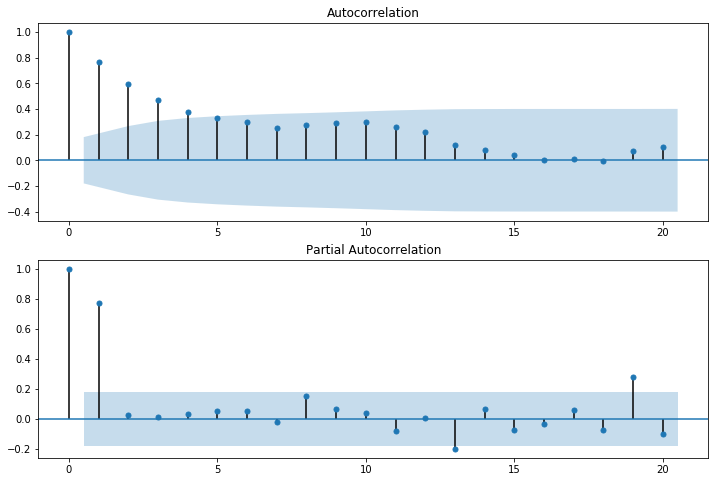

In [19]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid2, lags=20, ax=ax1)


#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid2, lags=20, ax=ax2)

## Paso 4: Combinar pasos 2 y 3 para estimar la ecuación completa.

En esta etapa, estimará A (L) y C (L) simultáneamente. Las propiedades de un modelo bien estimado son tales que los coeficientes son de alta calidad, el modelo es parsimonioso, los residuos se ajustan a un proceso de ruido blanco y los errores de pronóstico son pequeños. Debe comparar su modelo estimado con los otros candidatos posibles de los Pasos 2 y 3.

In [20]:
# X1 = [df['z'],df['lz'],df['ly']]
X1 = [df['z'],df['ly']]
X1 = np.column_stack(X1)
X1 = sm.add_constant(X1)

model3 = sm.OLS(df['y'],X1)
results3 = model3.fit()
resid3 = results3.resid
# print(results3.summary(xname=['const','z','lz','ly']))
print(results3.summary(xname=['const','z','ly']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     176.9
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           8.07e-36
Time:                        17:35:17   Log-Likelihood:                -156.71
No. Observations:                 118   AIC:                             319.4
Df Residuals:                     115   BIC:                             327.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0462      0.087     -0.531      0.5

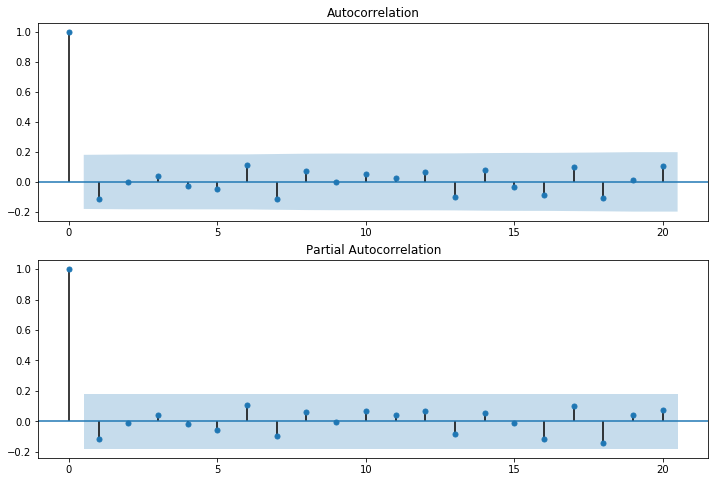

In [21]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid3, lags=20, ax=ax1)


#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid3, lags=20, ax=ax2)

In [3]:
italy = pd.read_excel(r'italy.xlsx')

In [4]:
italy.head()

,ENTRY,Slitaly,Attkit
0,1900-03-22 03:01:00,0.137936,0
1,1900-03-22 03:02:00,-0.013039,0
2,1900-03-22 03:03:00,0.050525,2
3,1900-03-22 03:04:00,0.126150,0
4,1900-03-22 04:01:00,0.182766,0


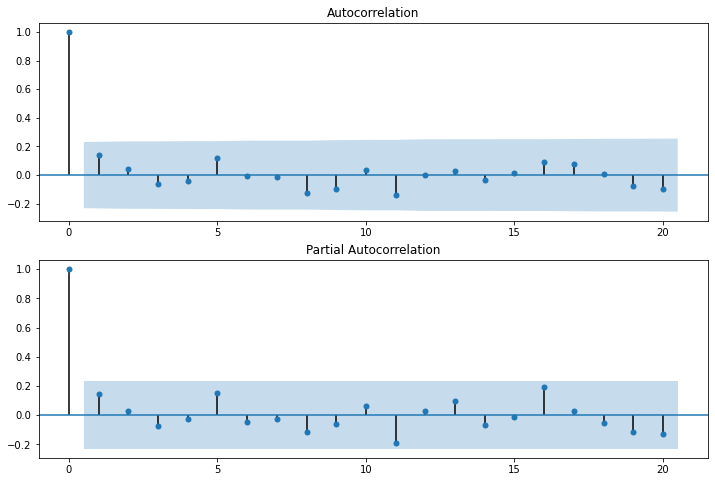

In [5]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(italy.Attkit, lags=20, ax=ax1)


#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(italy.Attkit, lags=20, ax=ax2)

_____

# Ideas finales


Estimar un  ADL  implica una combinación de habilidad, arte y perseverancia que se desarrolla a través de la práctica. 

Tenga en cuenta que el objetivo es encontrar una representación parsimoniosa de una interacción potencialmente complicada entre las variables. Los diferentes modelos ARMA pueden tener implicaciones económicas similares y generar pronósticos similares. Sin embargo, hay algunos consejos que pueden ser bastante útiles.

- Después de estimar el modelo completo en el Paso 4, si los residuos en $y_t=a_0 + \sum_{i=1}^p{a_iy_{t-i}} + \sum_{i=1}^n{c_iz_{t-i}}+e_t $ están correlacionados con $z_t$, la función $C(L)$ probablemente esté mal especificada. Regrese al Paso 3 y reformule las especificaciones de $A(L)$ y $C(L)$.

- Las correlaciones cruzadas muestral no son significativas si $y_t$ y/o $z_t$ no son estacionarias. Puede probar cada una por separadao usando DF test. En presencia de raíces unitarias, se  recomiendan diferenciar cada variable hasta que sea estacionaria. 

La interpretación de la ADL depende del tipo de diferenciación realizada. Considere las siguientes tres especificaciones y suponga que $|a_1|<1$:

1. $y_t = a_1y_{t-1} + c_0z_t + e_t$
2.  $\Delta y_t = a_1\Delta y_{t-1} + c_0z_t + e_t$ 
3. $y_t = a_1y_{t-1} + c_0\Delta z_t + e_t$


En (1), un choque de una unidad en $z_t$ tiene el efecto inicial de aumentar $y_t$ en unidades de $c_0$. Este efecto inicial decae a la tasa $a_1$. En (2), un choque de una unidad en $z_t$ tiene el efecto inicial de aumentar el cambio en $y_t$ en  $c_0$. El efecto sobre el cambio decae a la tasa $a_1$, pero el efecto sobre el nivel de $y_t$ nunca decae. En (3), solo el cambio en $z_t$ afecta a $y_t$. Aquí, el choque en la secuencia $z_t$ tendrá un efecto temporal en el nivel de $y_t$. 

Tenga en cuenta que es posible obtener un modelo más parsimonioso al permitir términos MA. 

_____

# Notas

1. Figura tomada de Wanter Enders (2015) Applied Econometric Time Series, Fourth Edition. Corresponde a la pagina 263, figura 5.3